# The spinodal in the regular solution model 

This Notebook is based on the one for the regular solution model. In addition to the miscibility gap, we include the spinodal curve.

The spinodal line separates the region where the Gibbs free energy has positive curvate from the region where the curvature is negative. For positive curvature, the material is stable against small thermal fluctuations of the composition. Inside the spinodal, where the curvature of the Gibbs free energy is negative, the material becomes unstable agains small thermal fluctuations of the composition. This instability leads to a growth of the composition fluctuation, leading to uphill diffusion and a spinodal transformation.

We will discuss the spinodal phase transformation in a separate Notebook.

### Preliminaries
Import the units, numerical, and plotting packages.

In [21]:
# Import NumPy numerical package
import numpy as np

# Import SciPy
import scipy as scipy
from scipy.optimize import fsolve, minimize, bisect

# Install the pint package using pip in the current Jupyter kernel
# To use pint, restart the kernel
import sys
!{sys.executable} -m pip install pint

# Disable Pint's old fallback behavior (must come before importing Pint)
import os
os.environ['PINT_ARRAY_PROTOCOL_FALLBACK'] = "0"

# Import Pint for units in Python
from pint import UnitRegistry
u = UnitRegistry(auto_reduce_dimensions=True)
u.default_format = 'P'

# plotting package
import matplotlib.pyplot as plt
%pylab inline
matplotlib.rcParams.update({'font.size': 24, 'text.usetex': False})

Populating the interactive namespace from numpy and matplotlib


/Users/rhennig/opt/anaconda3/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['axis']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


### Thermodynamic data
Set the thermodynamic constant and model parameters.

We use a regular solution model with positive departure from ideality that displays a miscibility gap and a spinodal.

In [22]:
# Gas constant
R = 8.314*u.J/u.mol/u.K

# Choice of temperature
T = 700*u.K

# Parameters for the regular solution models with positive departure from ideality, a1>0
a0 = +20*u.kJ/u.mol

# Return the enthalpy for a regular solution
def get_H_rs(T, a, x):
    H_rs = a * x * (1-x)
    return H_rs

# Return the Gibbs free energy of mixing for a regular solution
def get_G_rs(T, a, x):
    G_rs = a * x * (1-x) + R * T * (x * np.log(x) + (1-x)*np.log(1-x))
    return G_rs

### Calculate the enthalpy, entropy contribution, Gibbs free energy, and activities

In [23]:
# Array of compositions from 0 to 1
xv = np.linspace(0.0001,0.9999,500)

# Enthalpies of mixing
H = get_H_rs(T, a0, xv)

# Ideal entropy of mixing
S = -R * (xv * np.log(xv) + (1-xv)*np.log(1-xv))
TS = T*S

# Gibbs free energy of mixing
G = H - TS

### Plot the enthalpy, entropy contribution, and Gibbs free energy

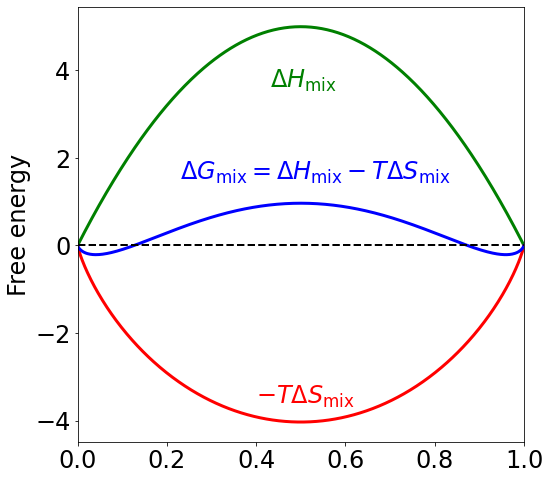

In [24]:
# Plot enthalpy and Gibbs free energy of mixing for both phases
fig, ax = plt.subplots(1, 1, figsize=(8,8))
#fig.tight_layout()

ax.plot(xv, (H/(u.kJ/u.mol)).magnitude, 'g-', linewidth=3.0)
ax.plot(xv, (-TS/(u.kJ/u.mol)).magnitude, 'r-', linewidth=3.0)
ax.plot(xv, (G/(u.kJ/u.mol)).magnitude, 'b-', linewidth=3.0)
ax.plot([0, 1], [0, 0], 'k--', linewidth=2.0)

ax.annotate('$\Delta H_\mathrm{mix}$', xy=(0.43,3.6), color='g', xycoords='data')
ax.annotate('$\Delta G_\mathrm{mix} = \Delta H_\mathrm{mix} - T\Delta S_\mathrm{mix}$', xy=(0.23,+1.5), color='b', xycoords='data')
ax.annotate('$- T\Delta S_\mathrm{mix}$', xy=(0.4,-3.6), color='r', xycoords='data')

ax.set_xlim([0, 1])
#ax.set_ylim([-11, 6])
ax.set_ylabel('Free energy')

plt.show()

### Temperature dependence of the Gibbs free energy for positive departure from ideality

Critical temperature =  1202.8 kelvin


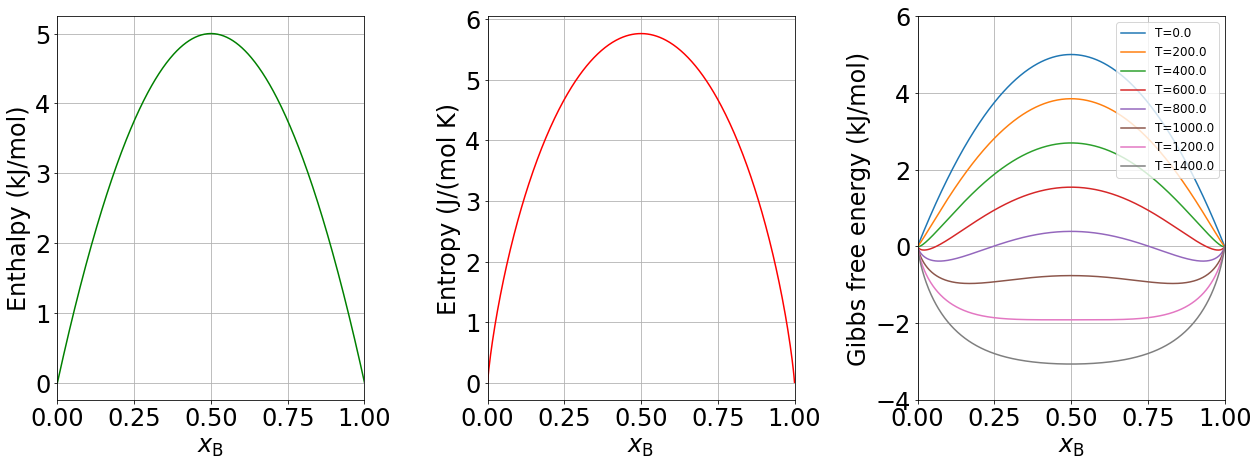

In [25]:
# Create a panel of three figures to show the enthalpy, entropy, and Gibbs free energy
fig, ax = plt.subplots(1, 3, figsize=(18,7))

# Plot the enthalpy
ax[0].plot(xv, (H/(u.kJ/u.mol)).magnitude, 'g-')
ax[0].set_xlabel('$x_\mathrm{B}$')
ax[0].set_ylabel('Enthalpy (kJ/mol)')
ax[0].set_xlim(0, 1) 
ax[0].grid() 

# Plot the entropy
ax[1].plot(xv, (S/(u.J/u.mol/u.K)).magnitude, 'r-')
ax[1].set_xlabel('$x_\mathrm{B}$')
ax[1].set_ylabel('Entropy (J/(mol K)')
ax[1].set_xlim(0, 1) 
ax[1].grid() 

# Critical temperture of the regular solution model
Tc = a0/2/R
print('Critical temperature = ', round(Tc, 1))

# Range of temperatures from zero to the critical temperature
Tmin = 0
Tmax = np.around((Tc/u.K).magnitude+200, decimals = -2)
Tsteps = (np.around(Tmax-Tmin)/200+1).astype(int)
tv = np.linspace(Tmin, Tmax, Tsteps)

# Plot Gibbs free energy as a function of temperature
ax[2].set_xlim(0, 1) 
ax[2].set_ylim(-4, 6) 

for t in np.nditer(tv):
    H = get_H_rs(t, a0, xv)
    G = H - t*u.K*S
    ax[2].plot(xv, (G/(u.kJ/u.mol)).magnitude, label=(r'T='+ str(t)))

ax[2].set_xlabel('$x_\mathrm{B}$')
ax[2].set_ylabel('Gibbs free energy (kJ/mol)')
ax[2].legend(prop={'size': 12}) 
ax[2].grid() 
fig.tight_layout()
plt.show() 

### Calculate the miscibility gap

**Question 1: What is the difference in the mathematical approach to calculate the spinodal compared to the miscibility gap?**

/Users/rhennig/opt/anaconda3/lib/python3.8/site-packages/pint/quantity.py:1215: RuntimeWarning: invalid value encountered in true_divide
  magnitude = magnitude_op(self._magnitude, other_magnitude)


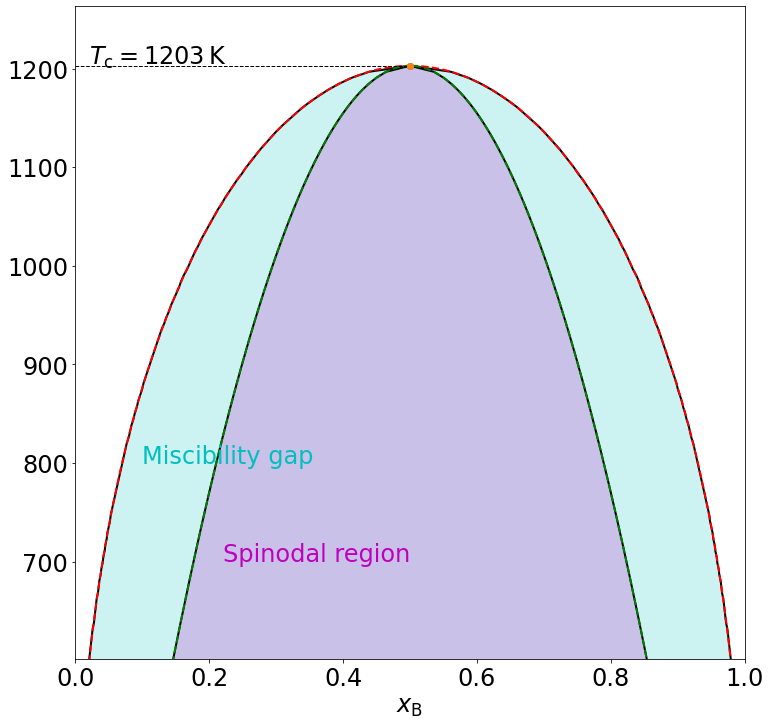

In [36]:
# Create a range of temperatures from half to one times the critical temperature
Num_T = 100
tv = np.linspace((Tc/u.K).magnitude/2, (Tc/u.K).magnitude, Num_T)
xv = np.linspace(0.001,0.5,500)
boundary = np.zeros(Num_T)
spinodal = np.zeros(Num_T)

# Calculate the common tangent using the fact that the regular solution model is symmetric.
# We just have to minimize G in the left and right half of the composition space.
# Also calculate the spinodal by finding the zeros of the second derivative of G(x)
S = -R * (xv * np.log(xv) + (1-xv)*np.log(1-xv))
i = 0

# Return the second derivative of the Gibbs free energy for a regular solution
def get_d2Gdx2(x):
    dx = 0.00001
    T = t*u.K
    d2Gdx2 = ((get_G_rs(T, a0, x-dx) + get_G_rs(T, a0, x+dx) - 2*get_G_rs(T, a0, x))/ (2*dx)).magnitude
    return d2Gdx2

def get_G(x, T):
    return (get_G_rs(T, a0, x)).magnitude

x=0.02
for t in np.nditer(tv):
    G1 = get_G_rs(t*u.K, a0, xv)
    boundary[i] = xv[np.argmin(G1)]
    spinodal[i] = bisect(get_d2Gdx2, boundary[i], 0.5)
    i=i+1
    
xv = np.linspace(0.001,0.999,999)

# Analytic Solution
# Setting the first derivative to zero, we obtain the boundary of the miscibility gap
T_b = a0/R*(1-2*xv)/np.log((1-xv)/xv)

# Setting the second derivative to zero, we obtain the spinodal line
T_s = 2*a0/R*(xv-xv*xv)

xboundary, yboundary = np.hstack((boundary, 1-boundary[::-1])), np.hstack((tv, tv[::-1]))
xspinodal, yspinodal = np.hstack((spinodal, 1-spinodal[::-1])), np.hstack((tv, tv[::-1]))

# Plot the results for phase diagram construction for three different temperatures
# (1) For T = Tc
t = round((Tc/u.K).magnitude)
G = get_G_rs(Tc, a0, xv)
plt.subplots(1, 1, figsize=(12,12))

plt.ylim((Tc/u.K).magnitude/2, (Tc/u.K).magnitude*1.05)
plt.xlim(0, 1)
plt.xlabel('$x_\mathrm{B}$')

plt.plot(xboundary, yboundary, 'k-', lw=2)
plt.plot(xspinodal, yspinodal, 'k-', lw=2)
plt.plot(xv, (T_b/u.K).magnitude, 'r--', lw=2)
plt.plot(xv, (T_s/u.K).magnitude, 'g--', lw=2)
plt.text(0.02, (Tc/u.K).magnitude+2, r'$T_\mathrm{{c}} = {:.0f}\,\mathrm{{K}}$'.format((Tc/u.K).magnitude))
plt.plot([0,0.5],[(Tc/u.K).magnitude, (Tc/u.K).magnitude], 'k--', lw=1)

plt.fill_between(xboundary, yboundary, color='c', alpha=0.2)
plt.fill_between(xspinodal, yspinodal, color='m', alpha=0.2)

plt.plot([0.5], [t], 'o')
plt.plot([0.5], [t], 'o')
plt.annotate('Miscibility gap', xy=(0.1, 800), color='c', xycoords='data')
plt.annotate('Spinodal region', xy=(0.22,700), color='m', xycoords='data')

fig.tight_layout()
plt.show() 

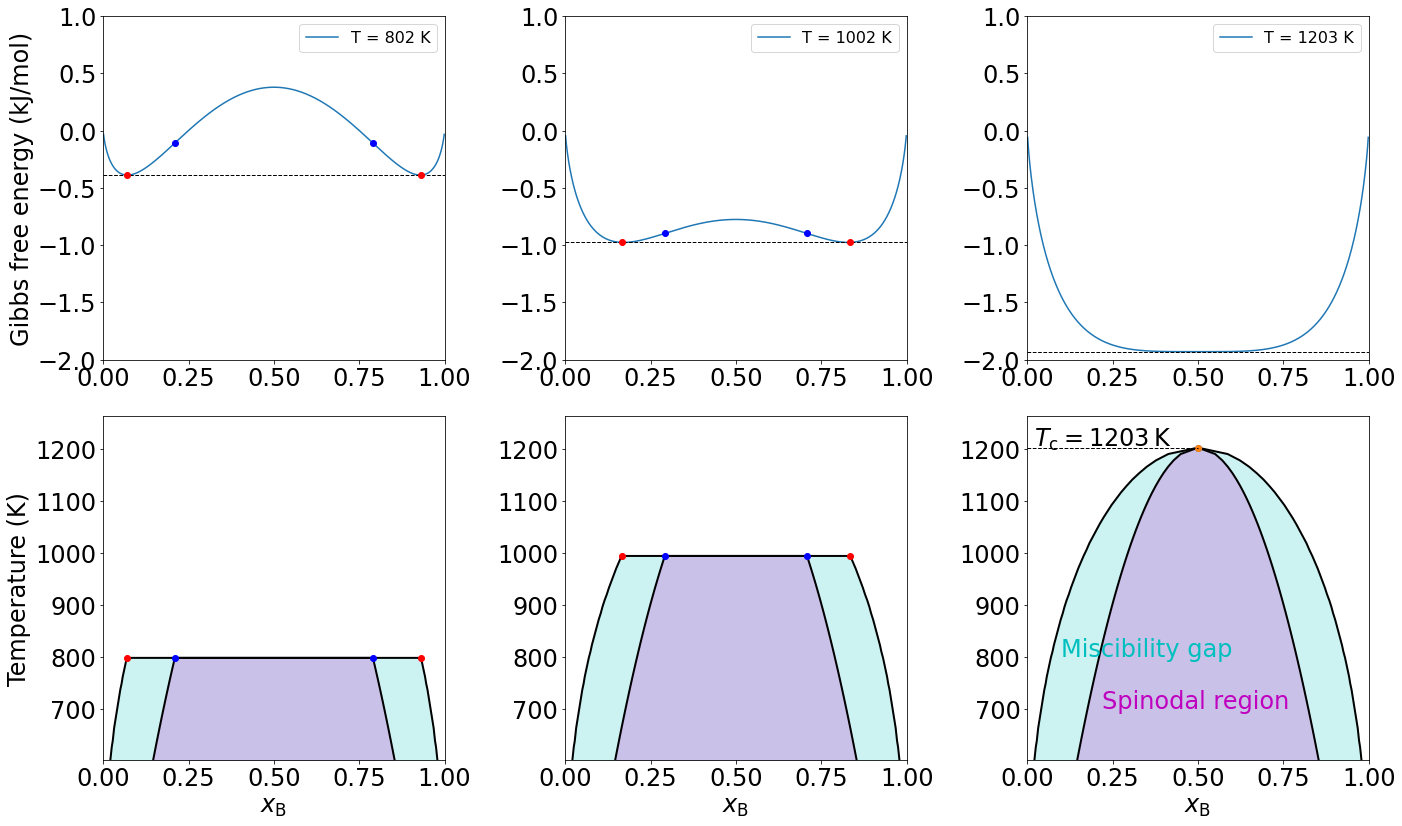

In [34]:
# Create a range of temperatures from half to one times the critical temperature
Num_T = 50
tv = np.linspace((Tc/u.K).magnitude/2, (Tc/u.K).magnitude, Num_T)
xv = np.linspace(0.001,0.5,500)
boundary = np.zeros(Num_T)
spinodal = np.zeros(Num_T)

# Calculate the common tangent using the fact that the regular solution model is symmetric.
# We just have to minimize G in the left and right half of the composition space.
# Also calculate the spinodal by finding the zeros of the second derivative of G(x)
S = -R * (xv * np.log(xv) + (1-xv)*np.log(1-xv))
i = 0

# Return the second derivative of the Gibbs free energy for a regular solution
def get_d2Gdx2(x):
    dx = 0.00001
    T = t*u.K
    d2Gdx2 = ((get_G_rs(T, a0, x-dx) + get_G_rs(T, a0, x+dx) - 2*get_G_rs(T, a0, x))/ (2*dx)).magnitude
    return d2Gdx2

def get_G(x, T):
    return (get_G_rs(T, a0, x)).magnitude

x=0.02
for t in np.nditer(tv):
    G1 = get_G_rs(t*u.K, a0, xv)
    boundary[i] = xv[np.argmin(G1)]
    spinodal[i] = bisect(get_d2Gdx2, boundary[i], 0.5)
    i=i+1
    
xv = np.linspace(0.001,0.999,999)

fig, ax = plt.subplots(2, 3, figsize=(20,12))
for i, axis in enumerate(ax.flat):
    axis.set_xlim(0, 1) 
    if(i>2):
        axis.set_ylim((Tc/u.K).magnitude/2, (Tc/u.K).magnitude*1.05)
        axis.set_xlabel('$x_\mathrm{B}$')
    else:
        axis.set_ylim(-2,1)

xboundary, yboundary = np.hstack((boundary, 1-boundary[::-1])), np.hstack((tv, tv[::-1]))
xspinodal, yspinodal = np.hstack((spinodal, 1-spinodal[::-1])), np.hstack((tv, tv[::-1]))

# Plot the results for phase diagram construction for three different temperatures
# (1) For T = Tc
t = round((Tc/u.K).magnitude)
G = get_G_rs(Tc, a0, xv)
ax[0,2].plot(xv, (G/(u.kJ/u.mol)).magnitude, label=(r'T = '+ str(t)+' K'))
ax[0,2].plot([0,1],[np.amin((G/(u.kJ/u.mol)).magnitude), np.amin((G/(u.kJ/u.mol)).magnitude)], 'k--', lw=1)
ax[0,2].legend(prop={'size': 16}) 
ax[1,2].plot(xboundary, yboundary, 'k-', lw=2)
ax[1,2].plot(xspinodal, yspinodal, 'k-', lw=2)
ax[1,2].fill_between(xboundary, yboundary, color='c', alpha=0.2)
ax[1,2].fill_between(xspinodal, yspinodal, color='m', alpha=0.2)

ax[1,2].plot([0.5], [t], 'o')
ax[1,2].plot([0.5], [t], 'o')
ax[1,2].annotate('Miscibility gap', xy=(0.1, 800), color='c', xycoords='data')
ax[1,2].annotate('Spinodal region', xy=(0.22,700), color='m', xycoords='data')


# (2) For T = 5/6 Tc
t = round((Tc/u.K).magnitude*5/6)
G = get_G_rs(Tc*5/6, a0, xv)
ax[0,1].plot(xv, (G/(u.kJ/u.mol)).magnitude, label=(r'T = '+ str(t)+' K'))
ax[0,1].plot([0,1],[np.amin((G/(u.kJ/u.mol)).magnitude), np.amin((G/(u.kJ/u.mol)).magnitude)], 'k--', lw=1)
ax[0,1].legend(prop={'size': 16}) 

# Data below T
xboundary=xboundary[yboundary<t]
yboundary=yboundary[yboundary<t]
xspinodal=xspinodal[yspinodal<t]
yspinodal=yspinodal[yspinodal<t]

ax[1,1].plot(xboundary, yboundary, 'k-', lw=2)
ax[1,1].plot(xspinodal, yspinodal, 'k-', lw=2)
ax[1,1].fill_between(xboundary, yboundary, color='c', alpha=0.2)
ax[1,1].fill_between(xspinodal, yspinodal, color='m', alpha=0.2)

i = np.argmax(tv[tv<t])
ax[1,1].plot([boundary[i], 1-boundary[i]], [tv[i], tv[i]], 'or')
ax[1,1].plot([spinodal[i], 1-spinodal[i]], [tv[i], tv[i]], 'ob')
G = (get_G_rs(Tc*5/6, a0, boundary[i])/u.kJ*u.mol).magnitude
ax[0,1].plot([boundary[i], 1-boundary[i]], [G, G] , 'or')
G = (get_G_rs(Tc*5/6, a0, spinodal[i])/u.kJ*u.mol).magnitude
ax[0,1].plot([spinodal[i], 1-spinodal[i]], [G, G], 'ob')


# (3) For T = 2/3 Tc
t = round((Tc/u.K).magnitude*2/3)
G = get_G_rs(Tc*2/3, a0, xv)
ax[0,0].plot(xv, (G/(u.kJ/u.mol)).magnitude, label=(r'T = '+ str(t)+' K'))
ax[0,0].plot([0,1],[np.amin((G/(u.kJ/u.mol)).magnitude), np.amin((G/(u.kJ/u.mol)).magnitude)], 'k--', lw=1)
ax[0,0].legend(prop={'size': 16}) 

# Data below T
xboundary=xboundary[yboundary<t]
yboundary=yboundary[yboundary<t]
xspinodal=xspinodal[yspinodal<t]
yspinodal=yspinodal[yspinodal<t]

ax[1,0].plot(xboundary, yboundary, 'k-', lw=2)
ax[1,0].plot(xspinodal, yspinodal, 'k-', lw=2)
ax[1,0].fill_between(xboundary, yboundary, color='c', alpha=0.2)
ax[1,0].fill_between(xspinodal, yspinodal, color='m', alpha=0.2)

i = np.argmax(tv[tv<t])
ax[1,0].plot([boundary[i], 1-boundary[i]], [tv[i], tv[i]], 'or')
ax[1,0].plot([spinodal[i], 1-spinodal[i]], [tv[i], tv[i]], 'ob')
G = (get_G_rs(Tc*2/3, a0, boundary[i])/u.kJ*u.mol).magnitude
ax[0,0].plot([boundary[i], 1-boundary[i]], [G, G] , 'or')
G = (get_G_rs(Tc*2/3, a0, spinodal[i])/u.kJ*u.mol).magnitude
ax[0,0].plot([spinodal[i], 1-spinodal[i]], [G, G], 'ob')

ax[1,2].text(0.02, (Tc/u.K).magnitude+2, r'$T_\mathrm{{c}} = {:.0f}\,\mathrm{{K}}$'.format((Tc/u.K).magnitude))
ax[1,2].plot([0,0.5],[(Tc/u.K).magnitude, (Tc/u.K).magnitude], 'k--', lw=1)

ax[0,0].set_ylabel('Gibbs free energy (kJ/mol)')
ax[1,0].set_ylabel('Temperature (K)')

fig.tight_layout()
plt.show() 